In [ ]:
import tensorflow as tf
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
!git clone https://github.com/Shankar0x/Datasets.git imgs

Cloning into 'imgs'...
remote: Enumerating objects: 9538, done.
remote: Total 9538 (delta 0), reused 0 (delta 0), pack-reused 9538
Receiving objects: 100% (9538/9538), 149.08 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (2230/2230), done.
Updating files: 100% (9861/9861), done.


In [ ]:
image_directory = 'imgs/Resized_Skin_Lesion_Dataset/Trainx/'
mask_directory = 'imgs/Resized_Skin_Lesion_Dataset/Trainy/'

In [ ]:
SIZE = 256
image_dataset = []
mask_dataset = []

In [ ]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'bmp'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [ ]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'bmp'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [ ]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = (np.expand_dims((np.array(mask_dataset)),3)>=125).astype('int16')

In [ ]:
np.unique(mask_dataset)

array([0, 1], dtype=int16)

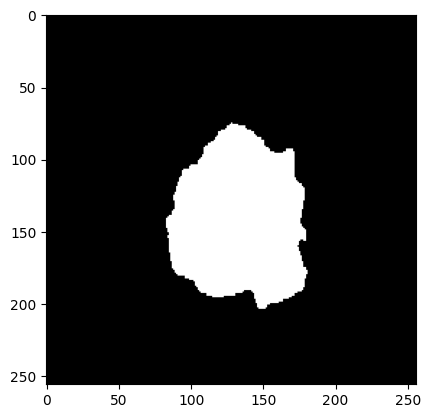

In [ ]:
plt.imshow(mask_dataset[55], cmap = 'gray')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

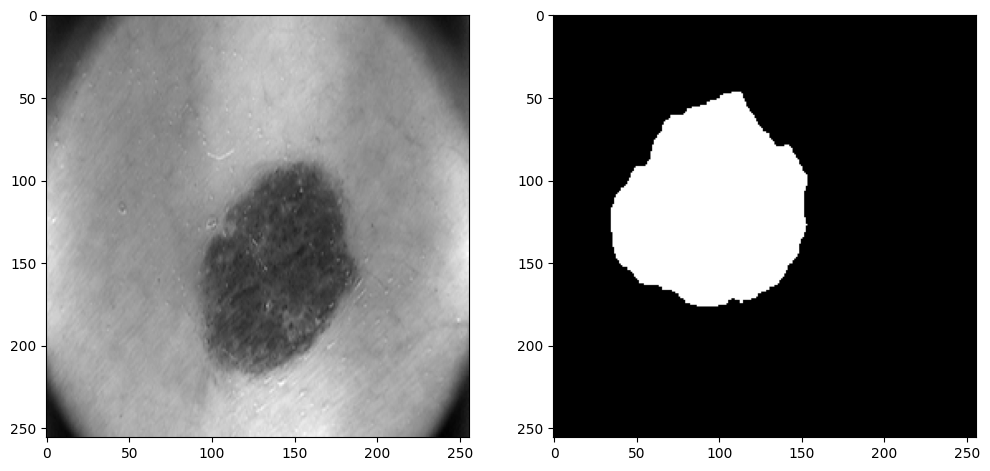

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size[0], image_size[1], 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=X_train[0].shape, num_classes=1)
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

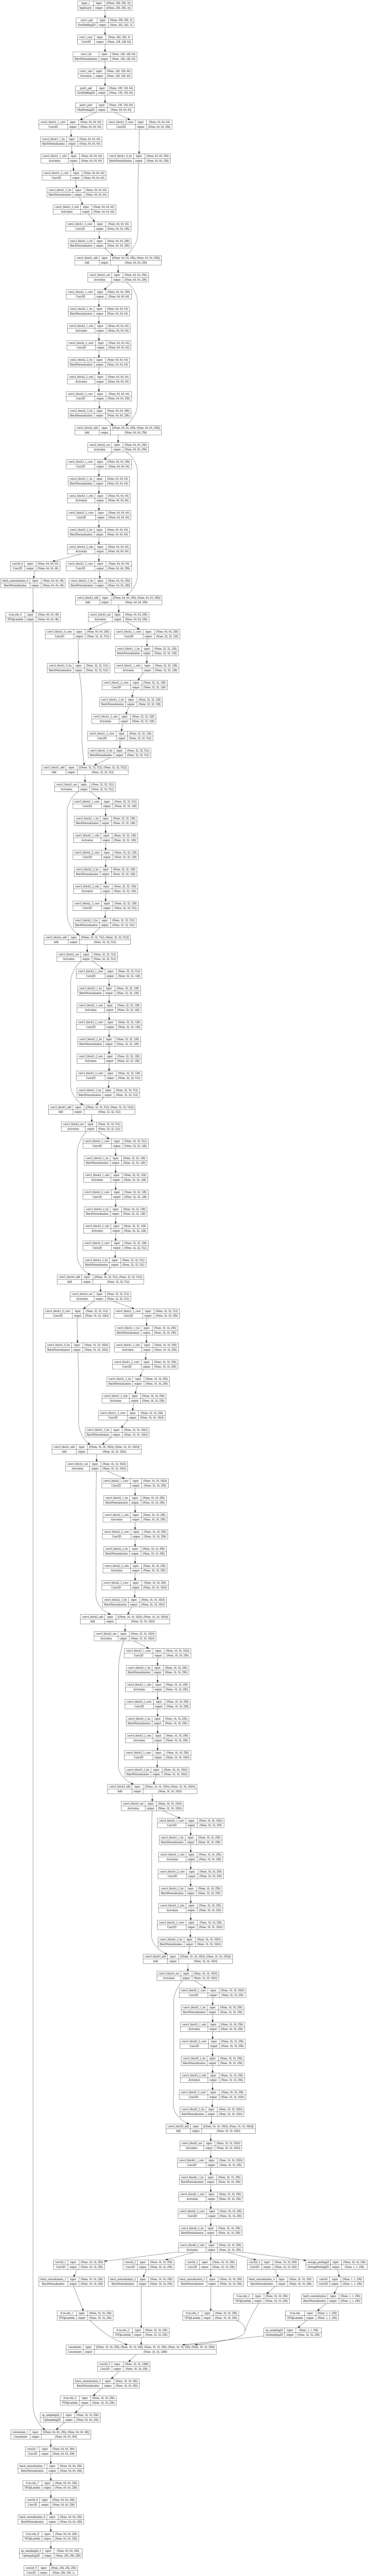

In [ ]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

In [ ]:
from keras.optimizers import Adam, SGD


IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


#If starting with pre-trained weights.
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')

model.compile(optimizer= SGD(learning_rate=0.001, nesterov=False), loss= ["binary_crossentropy"], metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size = 4,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False)


Epoch 1/100


ValueError: ignored

In [ ]:
# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 1s 907ms/step - loss: 0.1781 - accuracy: 0.9474
Accuracy =  94.73968744277954 %


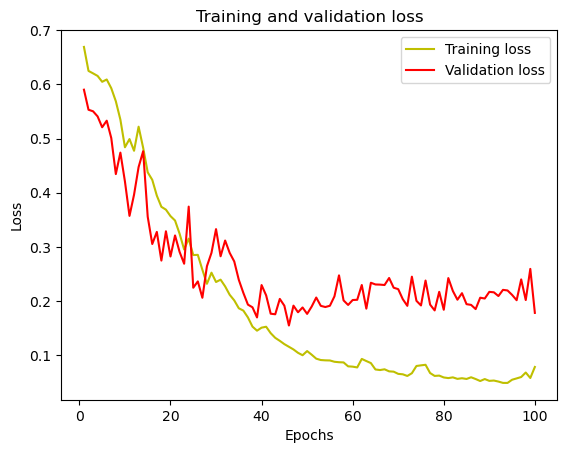

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

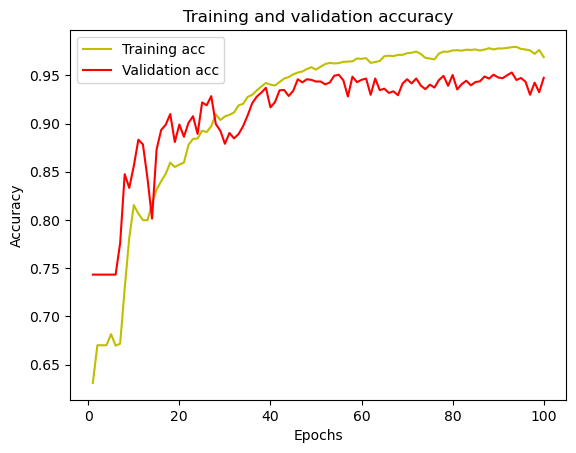

In [ ]:
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

1/1 [==============================] - 0s 250ms/step
IoU score is:  0.8058032570794441


In [ ]:
def enhance(img):
    sub = (model.predict(img.reshape(1,256,256,1))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

### In the above function, changed the threshold value to 0.2 from 0.5. This shows how much confidence our model shows in the prediction

1/1 [==============================] - 0s 26ms/step


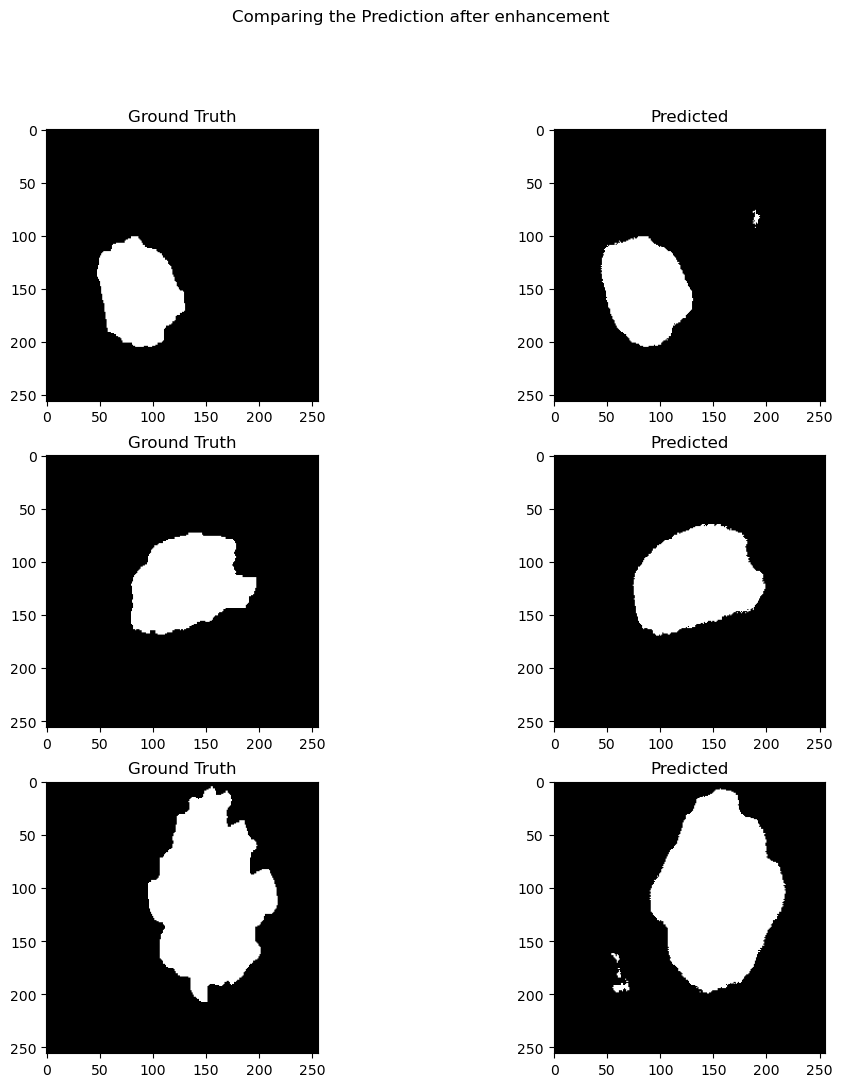

In [ ]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[9],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(X_test[9]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[13],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(X_test[13]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[17],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(X_test[17]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

In [ ]:
# All training images
sum_iou=0
for test_img_number in range(X_train.shape[0]):
    test_img = X_train[test_img_number]
    ground_truth=y_train[test_img_number]
    prediction = enhance(test_img).reshape(256,256)
    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/X_train.shape[0]
print("Mean IoU: ", m_iou_simple)

1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.90559936
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.8678572
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.91167885
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.84087825
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.8913611
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.8890141
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.91998553
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.9367038
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.8957275
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.87052023
1/1 [==============================] - 0s 26m

1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.76396525
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.94473153
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.8969851
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.87748945
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9183297
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9489796
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9220677
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.90612185
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.92151237
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.8837292
1/1 [==============================] - 0s 24m

1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9401364
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.96094644
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.95325124
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.8918381
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.86515224
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.88515997
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.94802165
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.917165
Mean IoU:  89.49663187066714


In [ ]:
# For all train images
pred_train_array = []
for i in X_train:
    pred_train_array.append(enhance(i).reshape(256,256))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


In [ ]:
print("Prediction array size: ", len(pred_train_array))

Prediction array size:  180


In [ ]:
flat_truth_arr = y_train.flatten()

In [ ]:
np.unique(flat_truth_arr)

array([0, 1], dtype=int16)

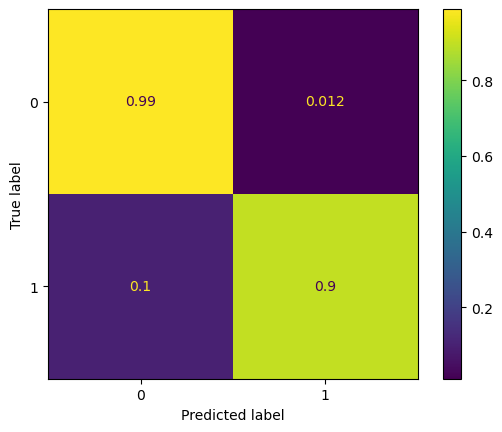

In [ ]:
flat_preds_arr = np.array(pred_train_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

In [ ]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [ ]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.8994887009459225
False Positive Rate(FPR):  0.011650853961969796
True Negative Rate(TNR):  0.10051129905407752
False Negative Rate(FNR):  0.9883491460380303


In [ ]:
print("F1 score of the predictions: ",f1_score(flat_truth_arr, flat_preds_arr, average='macro'))

F1 score of the predictions:  0.9527124112553286


In [ ]:
# Mean IoU for all testing images
sum_iou=0
for test_img_number in range(X_test.shape[0]):
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]

    prediction = enhance(test_img).reshape(256,256)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/X_test.shape[0]
print("Mean IoU: ", m_iou_simple)

1/1 [==============================] - 0s 33ms/step
IoU for the current prediction = 0.8461973
1/1 [==============================] - 0s 29ms/step
IoU for the current prediction = 0.9467142
1/1 [==============================] - 0s 31ms/step
IoU for the current prediction = 0.94904673
1/1 [==============================] - 0s 29ms/step
IoU for the current prediction = 0.3082499
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.9427432
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.9129833
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.9014326
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.79612625
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.88989687
1/1 [==============================] - 0s 27ms/step
IoU for the current prediction = 0.9421593
1/1 [==============================] - 0s 28ms/

In [ ]:
# For all test images
pred_test_array = []
for i in X_test:
    pred_test_array.append(enhance(i).reshape(256,256))

1/1 [==============================] - 0s 28ms/step


In [ ]:
print("Prediction array size: ", len(pred_test_array))

Prediction array size:  20


In [ ]:
flat_truth_arr = y_test.flatten()

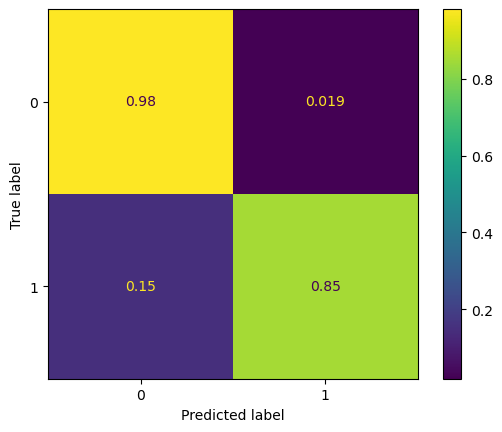

In [ ]:
flat_preds_arr = np.array(pred_test_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

In [ ]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [ ]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.8501242080990812
False Positive Rate(FPR):  0.019000439340250547
True Negative Rate(TNR):  0.14987579190091882
False Negative Rate(FNR):  0.9809995606597495


In [ ]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
